In [40]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf
import pyret.filtertools as ft
from pyret.nonlinearities import Binterp, Sigmoid
from scipy.optimize import minimize
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import collections
from tqdm import tqdm
import deepdish as dd
import pickle

from scipy.stats import sem
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
import torch
import torchdeepretina as tdr
import os

f2_response is unavailable until you run:
$ pip install -e git+git://github.com/nirum/jetpack.git@master#egg=jetpack


In [3]:
def white(time, contrast=1.0):
    compressed_time = int(np.ceil(time/3.0))
    compressed_stim = contrast * np.random.randn(compressed_time, 50, 50)
    stim = np.repeat(compressed_stim, 3, axis=0)

    return stim[:time]

In [4]:
# helper function to compute the STA using the model gradient
def compute_sta(model, contrast, cell_index):

    # generate some white noise
    X = tdr.stimuli.concat(white(5040, contrast=contrast))

    # compute the gradient of the model with respect to the stimulus
    drdx = tdr.utils.get_stim_grad(model, X, layer="output", cell_idx=cell_index, to_numpy=True, verbose=False)

    # average over the white noise samples
    sta = drdx.mean(axis=0)

    return sta

In [5]:
def normalize_filter(sta, stim, target_sd):
    '''Enforces filtered stimulus to have the same standard deviation
    as the stimulus.
    '''
    def sd_difference(theta):
        response = ft.linear_response(abs(theta) * sta, stim)
        return (np.std(response) - target_sd)**2
    
    res = minimize(sd_difference, x0=1.0)
    theta = abs(res.x)
    return (theta * sta, theta, res.fun)


In [6]:
def filter_and_nonlinearity(model, contrast, cell_index=0):

    # Fit linear filter
    sta = compute_sta(model, contrast=contrast, cell_index=cell_index)
    stim = white(4040, contrast=contrast)
    normed_sta, theta, error = normalize_filter(sta, stim, 0.35 * contrast)
    stim = torch.FloatTensor(tdr.stimuli.rolling_window(stim, 40))
    filtered_stim = tdr.utils.linear_response(torch.FloatTensor(normed_sta), stim, to_numpy=True)
    stim = stim.cuda()
    with torch.no_grad():
        response = model(stim)[:,cell_index].cpu().data.numpy()

    
    # Fit nonlinearity
    nonlinearity = Binterp(40)
#     nonlinearity = Sigmoid(peak=100.)
    nonlinearity.fit(filtered_stim[:-40], response)
    
    # Summarize model for plotting
    time = np.linspace(0.4, 0, 40)
    _, temporal = ft.decompose(normed_sta)
    temporal /= 0.01  # Divide by dt for y-axis to be s^{-1}
    
    x = np.linspace(np.min(filtered_stim), np.max(filtered_stim), 40)
    nonlinear_prediction = nonlinearity.predict(x)
    
    return time, temporal, x, nonlinear_prediction

In [ ]:
continuous_fast_adaptation = None

# Continuous change in nonlinearity

In [7]:
path = os.path.expanduser("~/src/torch-deep-retina/models/")
prepath = "convgc_"
savename = os.path.join(path, prepath+"15-10-07_naturalscene.pt")

In [8]:
model = tdr.io.load_model(savename)
model = model.to(torch.device('cuda:0'))
model = model.eval()

In [9]:
contrasts = np.linspace(0.2, 2.0, 10)
continuous_fast_adaptation = collections.defaultdict(list)
for contrast in tqdm(contrasts):
    time, temporal, x, nl = filter_and_nonlinearity(model, contrast=contrast, cell_index=0)
    continuous_fast_adaptation['time'].append(time)
    continuous_fast_adaptation['temporal'].append(temporal)
    continuous_fast_adaptation['x'].append(x)
    continuous_fast_adaptation['nl'].append(nl)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:28<00:00, 20.89s/it]


In [10]:
# cmap = plt.cm.get_cmap('RdYlGn')
cmap = plt.cm.get_cmap('winter')
colors = cmap(np.linspace(0, 1, 10))[::-1]

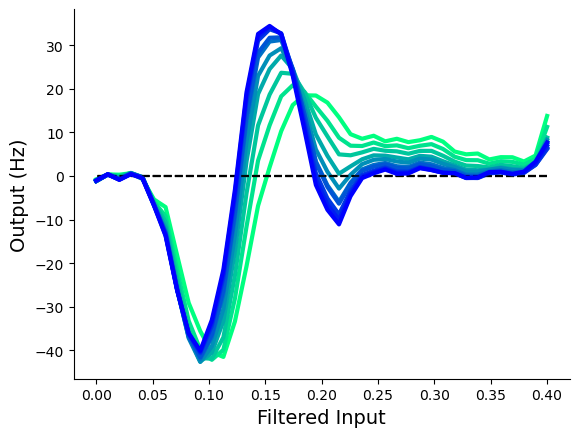

In [11]:
for idx, contrast in enumerate(contrasts):
    plt.plot(continuous_fast_adaptation['time'][idx], len(continuous_fast_adaptation['time'][idx]) * [0], 'k--', alpha=0.4)
    plt.plot(continuous_fast_adaptation['time'][idx], 
             np.sign(continuous_fast_adaptation['temporal'][idx][4]) * continuous_fast_adaptation['temporal'][idx], 
             linewidth=3, color=colors[idx])
    plt.xlabel('Filtered Input', fontsize=14)
    plt.ylabel('Output (Hz)', fontsize=14)
    ax1 = plt.gca()
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.xaxis.set_ticks_position('bottom')
    ax1.yaxis.set_ticks_position('left')
    majorLocator = MultipleLocator(1)
    majorFormatter = FormatStrFormatter('%d')
    minorLocator = MultipleLocator(0.5)
#     plt.savefig('Many contrast adaptation filter changes.png', transparent=True)

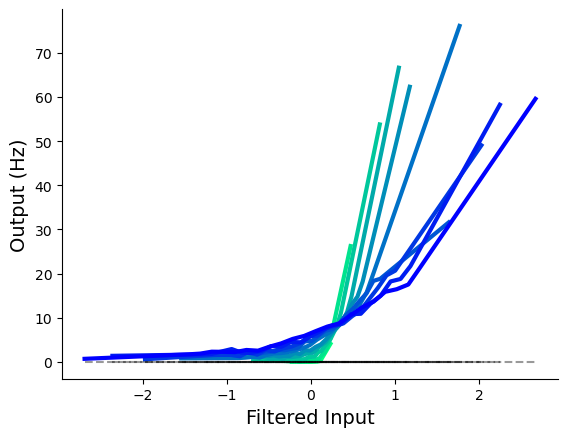

In [12]:
for idx, contrast in enumerate(contrasts):
    plt.plot(continuous_fast_adaptation['x'][idx], len(continuous_fast_adaptation['x'][idx]) * [0], 'k--', alpha=0.4)
    plt.plot(continuous_fast_adaptation['x'][idx], continuous_fast_adaptation['nl'][idx], linewidth=3, color=colors[idx])
    plt.xlabel('Filtered Input', fontsize=14)
    plt.ylabel('Output (Hz)', fontsize=14)
    ax1 = plt.gca()
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.xaxis.set_ticks_position('bottom')
    ax1.yaxis.set_ticks_position('left')
    majorLocator = MultipleLocator(1)
    majorFormatter = FormatStrFormatter('%d')
    minorLocator = MultipleLocator(0.5)
#     plt.savefig('Many contrast adaptation gain changes.png', transparent=True)

In [13]:
c = -1
thresh = 1
pos_x = [x for idx, x in enumerate(continuous_fast_adaptation['x'][c]) if continuous_fast_adaptation['nl'][c][idx] > thresh]
pos_y = [x for x in continuous_fast_adaptation['nl'][c] if x > thresh]
p = np.polyfit(pos_x, pos_y, 1)

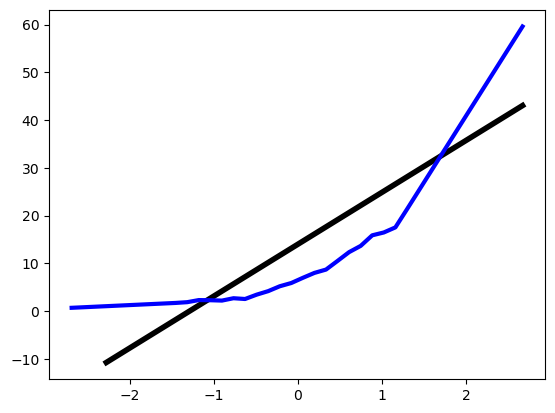

In [14]:
plt.plot(pos_x, p[0] * np.array(pos_x) + p[1], color='k', linewidth=4)
plt.plot(continuous_fast_adaptation['x'][c], continuous_fast_adaptation['nl'][c], linewidth=3, color=colors[idx])

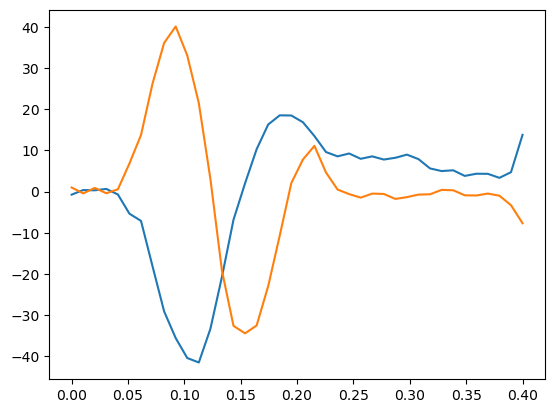

In [33]:
plt.plot(continuous_fast_adaptation['time'][0], continuous_fast_adaptation['temporal'][0])
plt.plot(continuous_fast_adaptation['time'][-1], -continuous_fast_adaptation['temporal'][-1])

In [15]:
def slope_statistic(filtered_input, output, thresh=1, ret_zero=True):
    if np.max(output) <= thresh:
        return 0 if ret_zero else np.nan
    
    # Used for og figure
    #pos_x = [x for idx, x in enumerate(filtered_input) if output[idx] > thresh]
    #pos_y = [x for x in output if x > thresh]
    
    # Ensures pos_x and pos_y line up appropriately
    temp_x = [x for idx, x in enumerate(filtered_input)]
    temp_y = [x for x in output]
    pos_x,pos_y = [],[]
    for idx, (px,py) in enumerate(zip(temp_x,temp_y)):
        if output[idx] > thresh and py > thresh:
               pos_x.append(px)
               pos_y.append(py)
    p = np.polyfit(pos_x, pos_y, 1)
    return p[0]

In [16]:
slope_statistic(continuous_fast_adaptation['x'][c], continuous_fast_adaptation['nl'][c])

10.86644517370575

# Generate population summary

In [17]:
amps = abs(np.fft.rfft(np.random.randn(10)))

In [18]:
freqs = np.fft.rfftfreq(10, 0.01)

In [19]:
sum([f * a for f,a in zip(freqs, amps)])/sum(amps)

20.389020063121638

In [20]:
def center_of_mass(x, y):
    """Returns center of mass x with weights y."""
    return sum([x * y for x,y in zip(x, y)])/sum(y)

In [21]:
def all_statistics(model, contrast, stas=None, norm_scale=0.35, slope_threshold=1):
    """
    stas: none or list of torch tensors
        if list, should be sta for each cell
    """
    cells = model.n_units

    stats = []
    freqs = []
    normed_stas = []
    filtered_stims = []
    resps = []
    
    stim = white(4040, contrast=contrast)
    inpt = torch.FloatTensor(tdr.stimuli.rolling_window(stim, 40))
    with torch.no_grad():
        responses = model(inpt.cuda()).cpu().data.numpy()
    for cell_index in tqdm(range(cells)):
        # Fit linear filter
        if stas is None:
            sta = compute_sta(model, cell_index=cell_index, contrast=contrast)
        else: sta = stas[cell_index]
        normed_sta, theta, error = normalize_filter(sta, stim, norm_scale * contrast)
        normed_stas.append(normed_sta)
        with torch.no_grad():
            filtered_stim = tdr.utils.linear_response(torch.FloatTensor(normed_sta), inpt, to_numpy=True)
            
        response = responses[:,cell_index] # Model response
        
        filtered_stims.append(filtered_stim)
        resps.append(response)
        
        # Fit nonlinearity
        nonlinearity = Binterp(40)
#         nonlinearity = Sigmoid(peak=100.)
        nonlinearity.fit(filtered_stim[:-40], response)

        # Summarize model for plotting
        time = np.linspace(0.4, 0, 40)
        _, temporal = ft.decompose(normed_sta)
        temporal /= 0.01  # Divide by dt for y-axis to be s^{-1}
        amps = abs(np.fft.rfft(temporal))
        fs = np.fft.rfftfreq(len(temporal), abs(np.mean(np.diff(time))))
        mass_center = center_of_mass(fs, amps)
        freqs.append(mass_center)

        x = np.linspace(np.min(filtered_stim), np.max(filtered_stim), 40)
        nonlinear_prediction = nonlinearity.predict(x)
        # Changed thresh from 1 to 0
        stat = slope_statistic(x, nonlinear_prediction, thresh=slope_threshold)
        stats.append(stat)
    
    return freqs, stats, normed_stas, filtered_stims, resps

In [22]:
expts = ['15-10-07', '15-11-21a', '15-11-21b']
# expts = ['15-10-07']
stimuli = ['whitenoise', 'naturalscene']

In [26]:
sta_path = prepath+"fastadapt_stas.p"

In [27]:
contrasts = [.5, 1, 1.5, 2]
models = {stim: {expt: None for expt in expts} for stim in stimuli}
for stim in stimuli:
    for expt in expts:
        print("Loading", stim, expt, "model")
        savefile = os.path.expanduser(os.path.join("~/src/torch-deep-retina/models", 
                                                   "{}{}_{}.pt".format(prepath,expt,stim)))
        model = tdr.io.load_model(savefile)
        model.eval()
        models[stim][expt] = model
        
if os.path.exists(sta_path):
    with open(sta_path, "rb") as f:
        stas = pickle.load(f)
else:
    stas = {stim: {expt: {c:[] for c in contrasts} for expt in expts} for stim in stimuli}
    for stim in stimuli:
        for expt in expts:
            print("Beginning", stim, expt)
            model = models[stim][expt]
            if not os.path.exists(sta_path):
                model.cuda()
                for contrast in tqdm(contrasts):
                    for ci in range(model.n_units):
                        sta = compute_sta(model, cell_index=ci, contrast=contrast, n_samples=5000)
                        stas[stim][expt][contrast].append(sta)
                model.cpu()
        with open(sta_path, "wb") as f:
            pickle.dump(stas, f)
    


Loading whitenoise 15-10-07 model
Loading whitenoise 15-11-21a model
Loading whitenoise 15-11-21b model
Loading naturalscene 15-10-07 model
Loading naturalscene 15-11-21a model
Loading naturalscene 15-11-21b model


In [28]:
threshold = 0.5
scale = 0.35

path = prepath + "nonlinslopes_data_thresh{}_scale{}.p".format(threshold, scale)
if os.path.exists(path):
    with open(path, "rb") as f:
        data = pickle.load(f)
    frequency_center_of_mass = data["frequency_center_of_mass"]
    gain_slopes = data["gain_slopes"]
    normed_stas = data["normed_stas"]
    filtered_stims = data["filtered_stims"]
    responses = data["responses"]
    
else:
    frequency_center_of_mass = {'whitenoise': collections.defaultdict(list), 'naturalscene': collections.defaultdict(list)}
    gain_slopes = {'whitenoise': collections.defaultdict(list), 'naturalscene': collections.defaultdict(list)}
    normed_stas = {stim: {expt: {c: None for c in contrasts} for expt in expts} for stim in stimuli}
    filtered_stims = {stim: {expt: {c: None for c in contrasts} for expt in expts} for stim in stimuli}
    responses = {stim: {expt: {c: None for c in contrasts} for expt in expts} for stim in stimuli}
    
    for stim in stimuli:
        for expt in expts:
            try:
                print("Starting", expt, stim)
                model = models[stim][expt]
                model.cuda()
                model.eval()
                for contrast in contrasts:
                    print("Contrast", contrast)
                    f, s, nrm_stas, filt_stims, resps = all_statistics(
                        model, contrast, stas=stas[stim][expt][contrast],
                        norm_scale=scale, slope_threshold=threshold
                    )
                    frequency_center_of_mass[stim][contrast].extend(f)
                    gain_slopes[stim][contrast].extend(s)
                    normed_stas[stim][expt][contrast] = nrm_stas
                    filtered_stims[stim][expt][contrast] = filt_stims
                    responses[stim][expt][contrast] = resps
                model.cpu()
            except:
                model.cpu()
                assert False
    data = {
        "frequency_center_of_mass": frequency_center_of_mass,
        "gain_slopes": gain_slopes,
        "normed_stas": normed_stas,
        "filtered_stims": filtered_stims,
        "responses": responses,
    }
    with open(path, "wb") as f:
        pickle.dump(data, f)


Starting 15-10-07 whitenoise


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:04<00:00, 12.85s/it]


Starting 15-11-21a whitenoise


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:48<00:00, 12.14s/it]


Starting 15-11-21b whitenoise


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [03:26<00:00, 12.15s/it]


Starting 15-10-07 naturalscene


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:58<00:00, 11.65s/it]


Starting 15-11-21a naturalscene


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.44s/it]


Starting 15-11-21b naturalscene


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [03:15<00:00, 11.49s/it]


In [29]:
#frequency_center_of_mass = {'whitenoise': collections.defaultdict(list), 'naturalscene': collections.defaultdict(list)}
#gain_slopes = {'whitenoise': collections.defaultdict(list), 'naturalscene': collections.defaultdict(list)}
#
#contrasts = [.5, 1, 1.5, 2]
#for contrast in contrasts:
#    for stim in stimuli:
#        for expt in expts:
#            print("Starting", expt, stim, contrast)
#            savefile = os.path.expanduser(os.path.join("~/src/torch-deep-retina/models", 
#                                                       "{}{}_{}.pt".format(prepath,expt,stim)))
#            model = tdr.io.load_model(savefile)
#            model.cuda()
#            model.eval()
#            f, s = all_statistics(model, contrast)
#            frequency_center_of_mass[stim][contrast].extend(f)
#            gain_slopes[stim][contrast].extend(s)
#            model.cpu()

In [30]:
## Optionally convert Nones to zeros (we do not do this for paper)
#for stim in gain_slopes.keys():
#    for contrast in gain_slopes[stim].keys():
#        gain_slopes[stim][contrast] = np.asarray([x if x else 0 for x in gain_slopes[stim][contrast]])

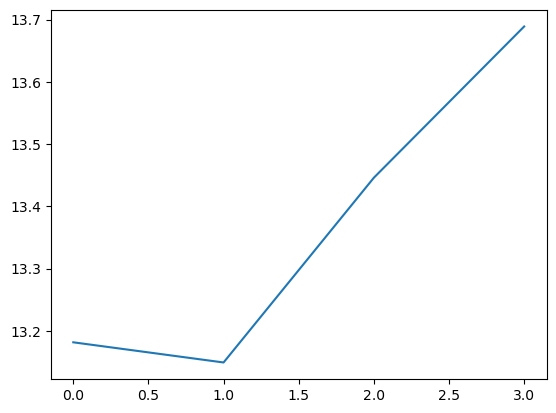

In [31]:
plt.plot([np.mean(frequency_center_of_mass['naturalscene'][contrast]) for contrast in contrasts])

Text(0, 0.5, 'Frequency (Hz)')

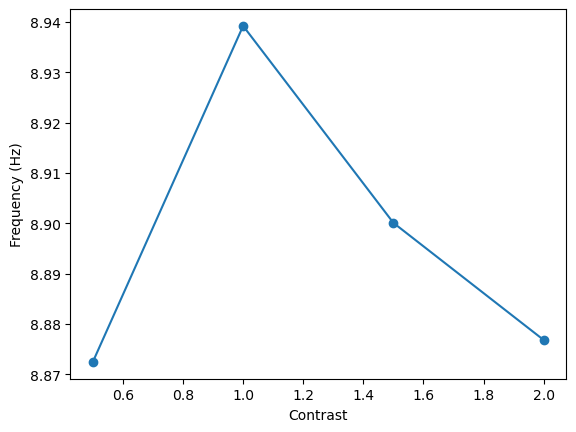

In [32]:
plt.plot(contrasts, [np.mean(frequency_center_of_mass['whitenoise'][contrast]) for contrast in contrasts], 'o-')
plt.xlabel('Contrast')
plt.ylabel('Frequency (Hz)')

5.914704324077579
7.153086050773767


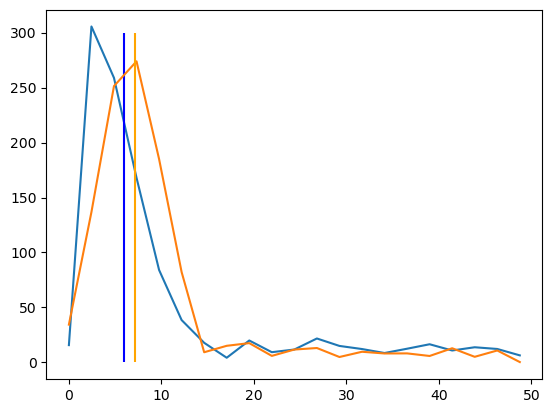

In [34]:
if continuous_fast_adaptation is not None:
    time = -continuous_fast_adaptation['time'][0]
    temporal = continuous_fast_adaptation['temporal'][0]
    
    amps = abs(np.fft.rfft(temporal))
    fs = np.fft.rfftfreq(len(temporal), abs(np.mean(np.diff(time))))
    plt.plot(fs, amps)
    mass_center = center_of_mass(fs[:10], amps[:10])
    plt.vlines(mass_center, 0, 300, color='b')
    print(mass_center)
    
    
    time = -continuous_fast_adaptation['time'][-1]
    temporal = continuous_fast_adaptation['temporal'][-1]
    
    amps = abs(np.fft.rfft(temporal))
    fs = np.fft.rfftfreq(len(temporal), abs(np.mean(np.diff(time))))
    plt.plot(fs, amps)
    mass_center = center_of_mass(fs[:10], amps[:10])
    plt.vlines(mass_center, 0, 300, color='orange')
    print(mass_center)

In [35]:
center_of_mass(fs[:10], amps[:10])

7.153086050773767

In [36]:
sum(fs[:10] * amps[:10])/sum(amps[:10])

7.153086050773767

In [37]:
sum(fs * amps)/sum(amps)

9.454531656176947

In [38]:
plt.style.use('deepretina.mplstyle')

In [48]:
gain_slopes_no_nones = {}
for stim in stimuli:
    gain_slopes_no_nones[stim] = {}
    for contrast in contrasts:
        gain_slopes_no_nones[stim][contrast] = [x for x in gain_slopes[stim][contrast] if x and x < 1000]
        gain_slopes[stim][contrast] = [x if x==x else 0 for x in gain_slopes[stim][contrast]]

In [49]:
rootpath = '/home/grantsrb/src/torch-deep-retina/models/'
prename = prepath
DEVICE = torch.device('cuda:0')
savefolder = "FigureUpdates_March2023/"
caption_file = "captions.txt"
captions = dict()

Text(1, 1.05, 'Natural Scenes')

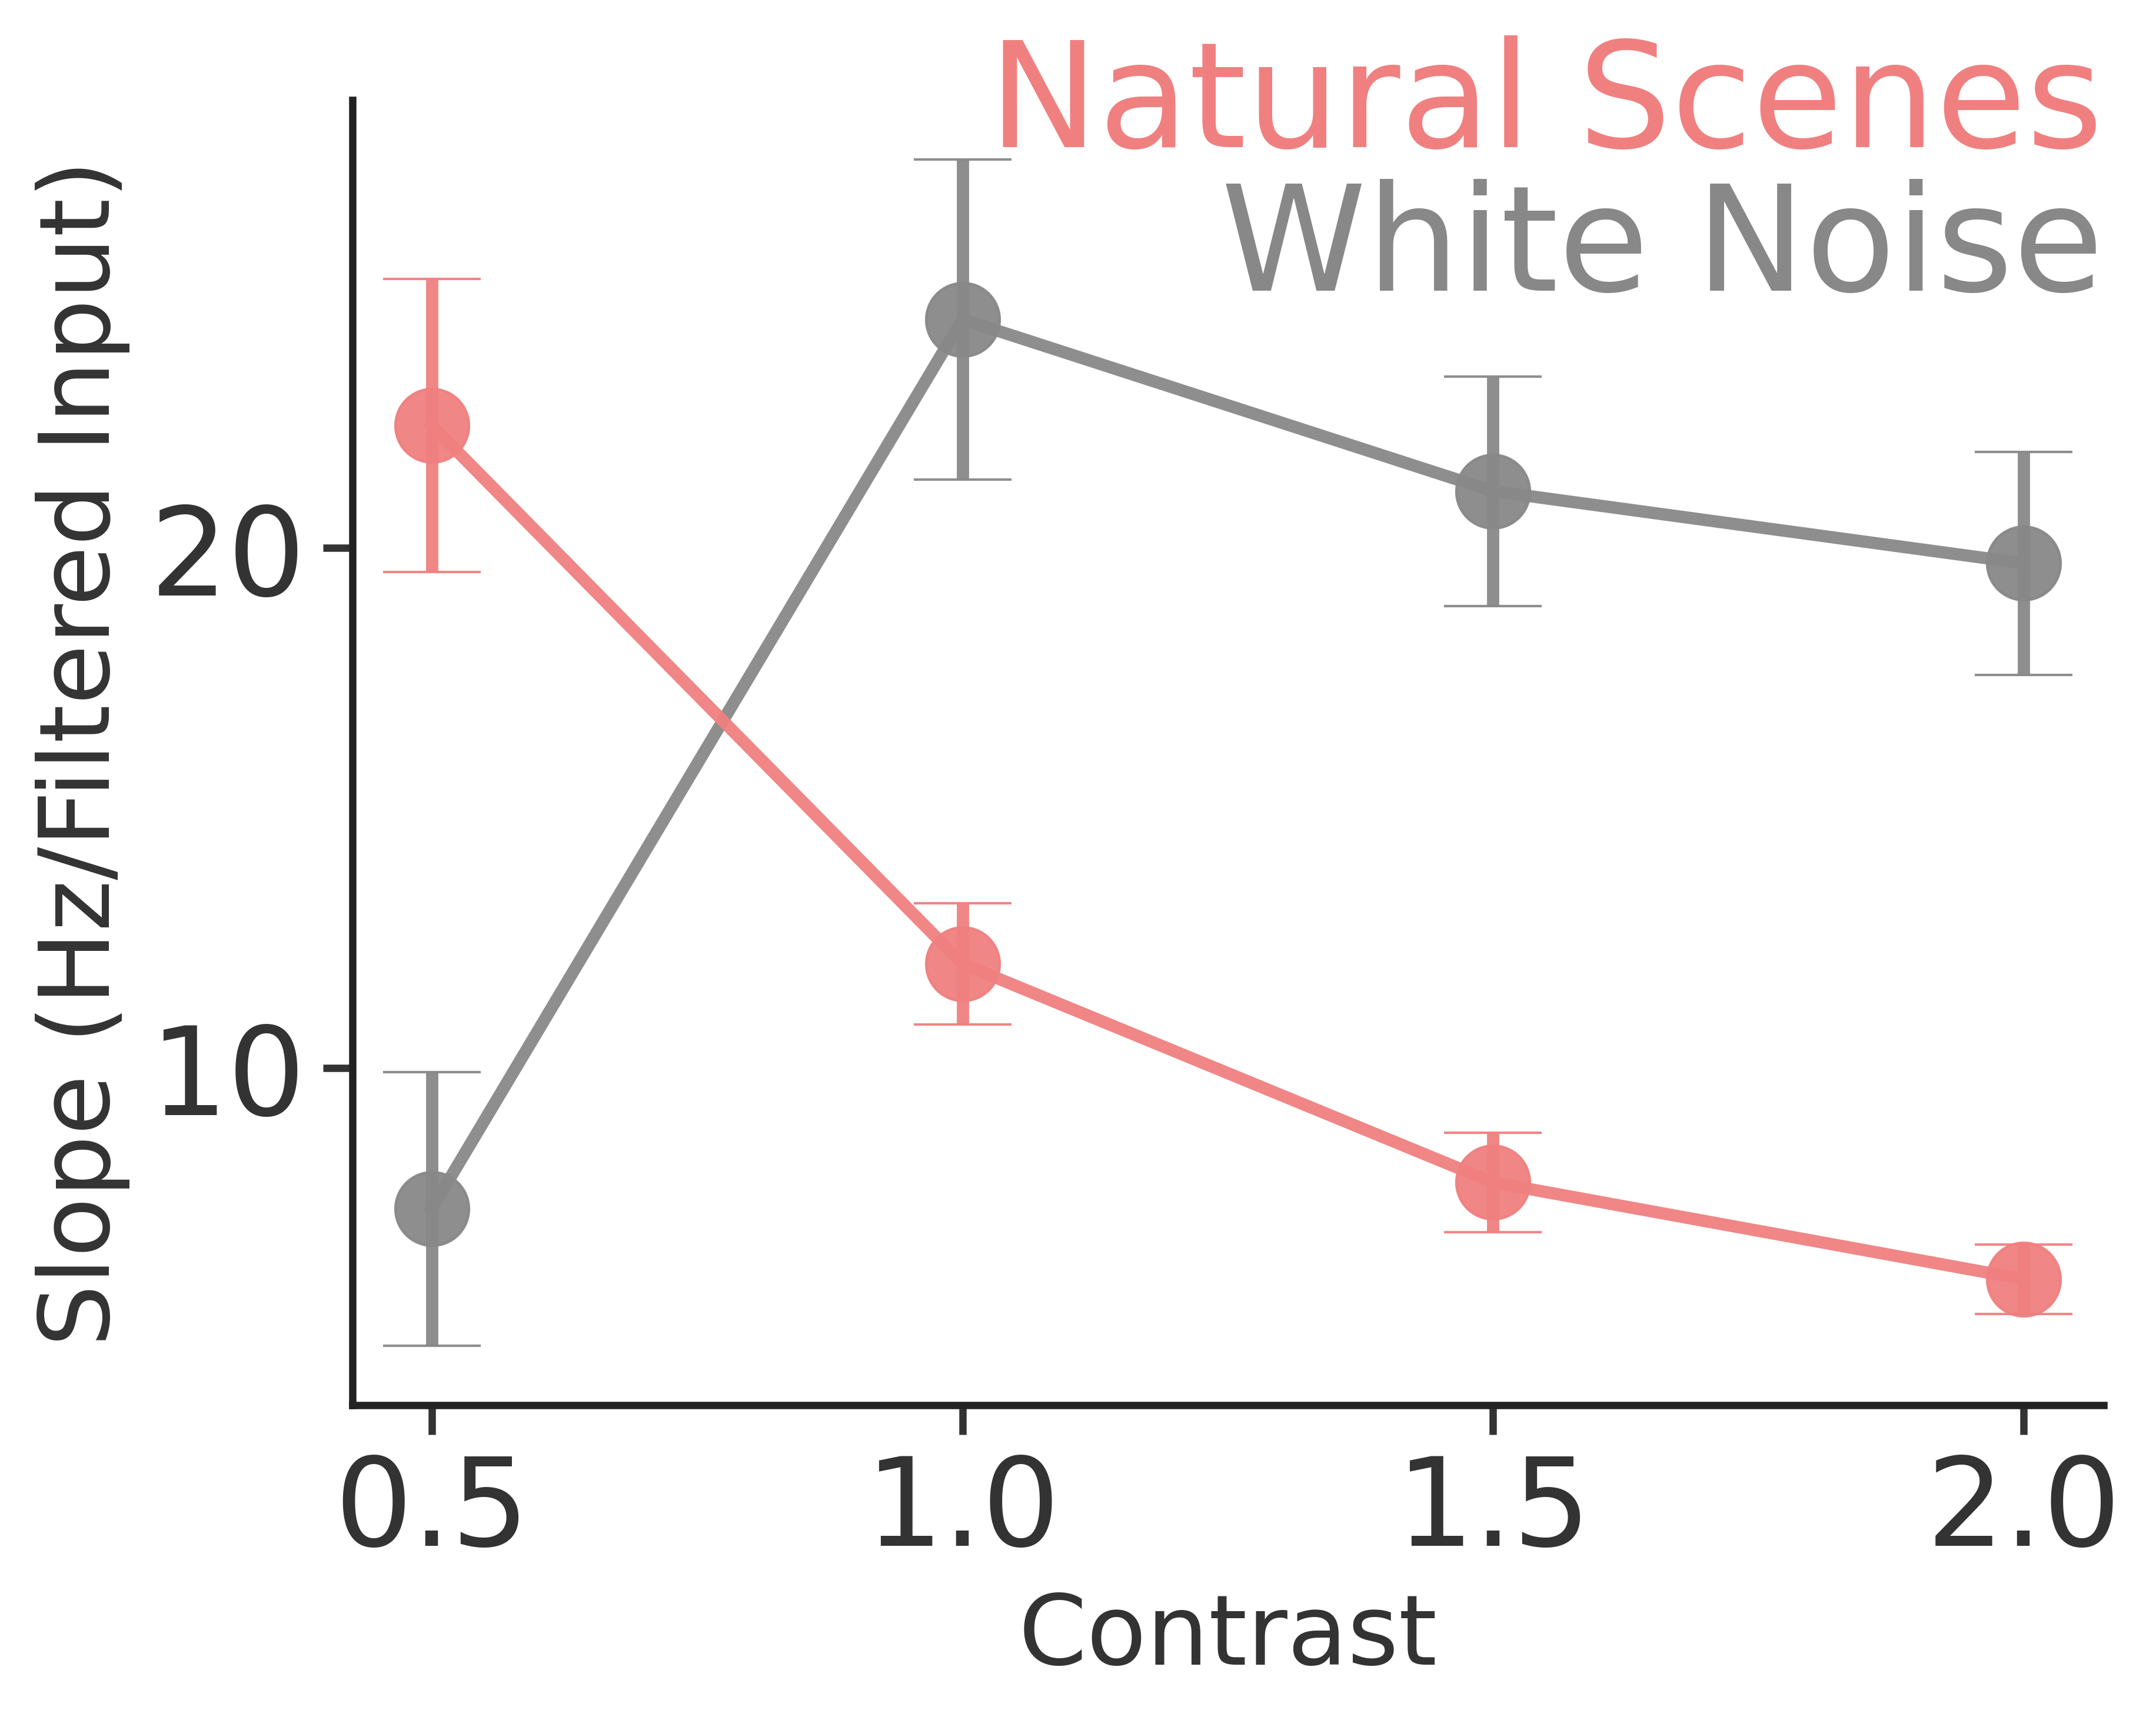

In [50]:
# plt.plot(contrasts, [np.mean(gain_slopes['naturalscene'][contrast]) for contrast in contrasts], 'o')
legendsize = 30
ticksize = 25
nat_color = 'lightcoral'
whit_color = '#888888'
alpha = 0.95
capsize = 10
plt.errorbar(contrasts, [np.mean(gain_slopes['whitenoise'][contrast]) for contrast in contrasts], 
             yerr=[sem(gain_slopes['whitenoise'][contrast]) for contrast in contrasts],
             fmt='o', color=whit_color, label='white noise', alpha=alpha, capsize=capsize)
plt.errorbar(contrasts, [np.mean(gain_slopes['naturalscene'][contrast]) for contrast in contrasts], 
             yerr=[sem(gain_slopes['naturalscene'][contrast]) for contrast in contrasts],
             fmt='o', color=nat_color, label='natural scenes', alpha=alpha, capsize=capsize)
plt.plot(contrasts, [np.mean(gain_slopes['whitenoise'][contrast]) for contrast in contrasts], 
             color=whit_color, label='white noise', alpha=alpha)
plt.plot(contrasts, [np.mean(gain_slopes['naturalscene'][contrast]) for contrast in contrasts], 
             color=nat_color, label='natural scenes', alpha=alpha)
plt.xlabel('Contrast', fontsize=20)
plt.ylabel('Slope (Hz/Filtered Input)', fontsize=20)

ax1 = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.locator_params(nbins=4)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)

plt.text(1,.94, 'White Noise', ha="right", va="top", transform=plt.gca().transAxes, 
                                                                     color=whit_color,
                                                                     fontsize=legendsize)
plt.text(1,1.05, 'Natural Scenes', ha="right", va="top", transform=plt.gca().transAxes, 
                                                                         color=nat_color,
                                                                         fontsize=legendsize)
#folder_name = "contrast_adapt"
#folder = os.path.join(savefolder, "contrast_adapt")
#if not os.path.exists(folder):
#    os.makedirs(folder)
#save_name = os.path.join(folder, "{}nonlinearity_slopes".format(prename))
#plt.savefig(save_name + ".png", bbox_inches="tight")
#plt.savefig(save_name + ".pdf", bbox_inches="tight")
#plt.show()
#
#captions[save_name.split("/")[-1]] = """
#Slopes of the contrast adaptation nonlinearity for different contrasts, averaged over all cells.
#"""
#
#with open(os.path.join(folder, caption_file), "w") as f:
#    for k,v in captions.items():
#        f.write(k+":\n")
#        f.write(v+"\n\n")

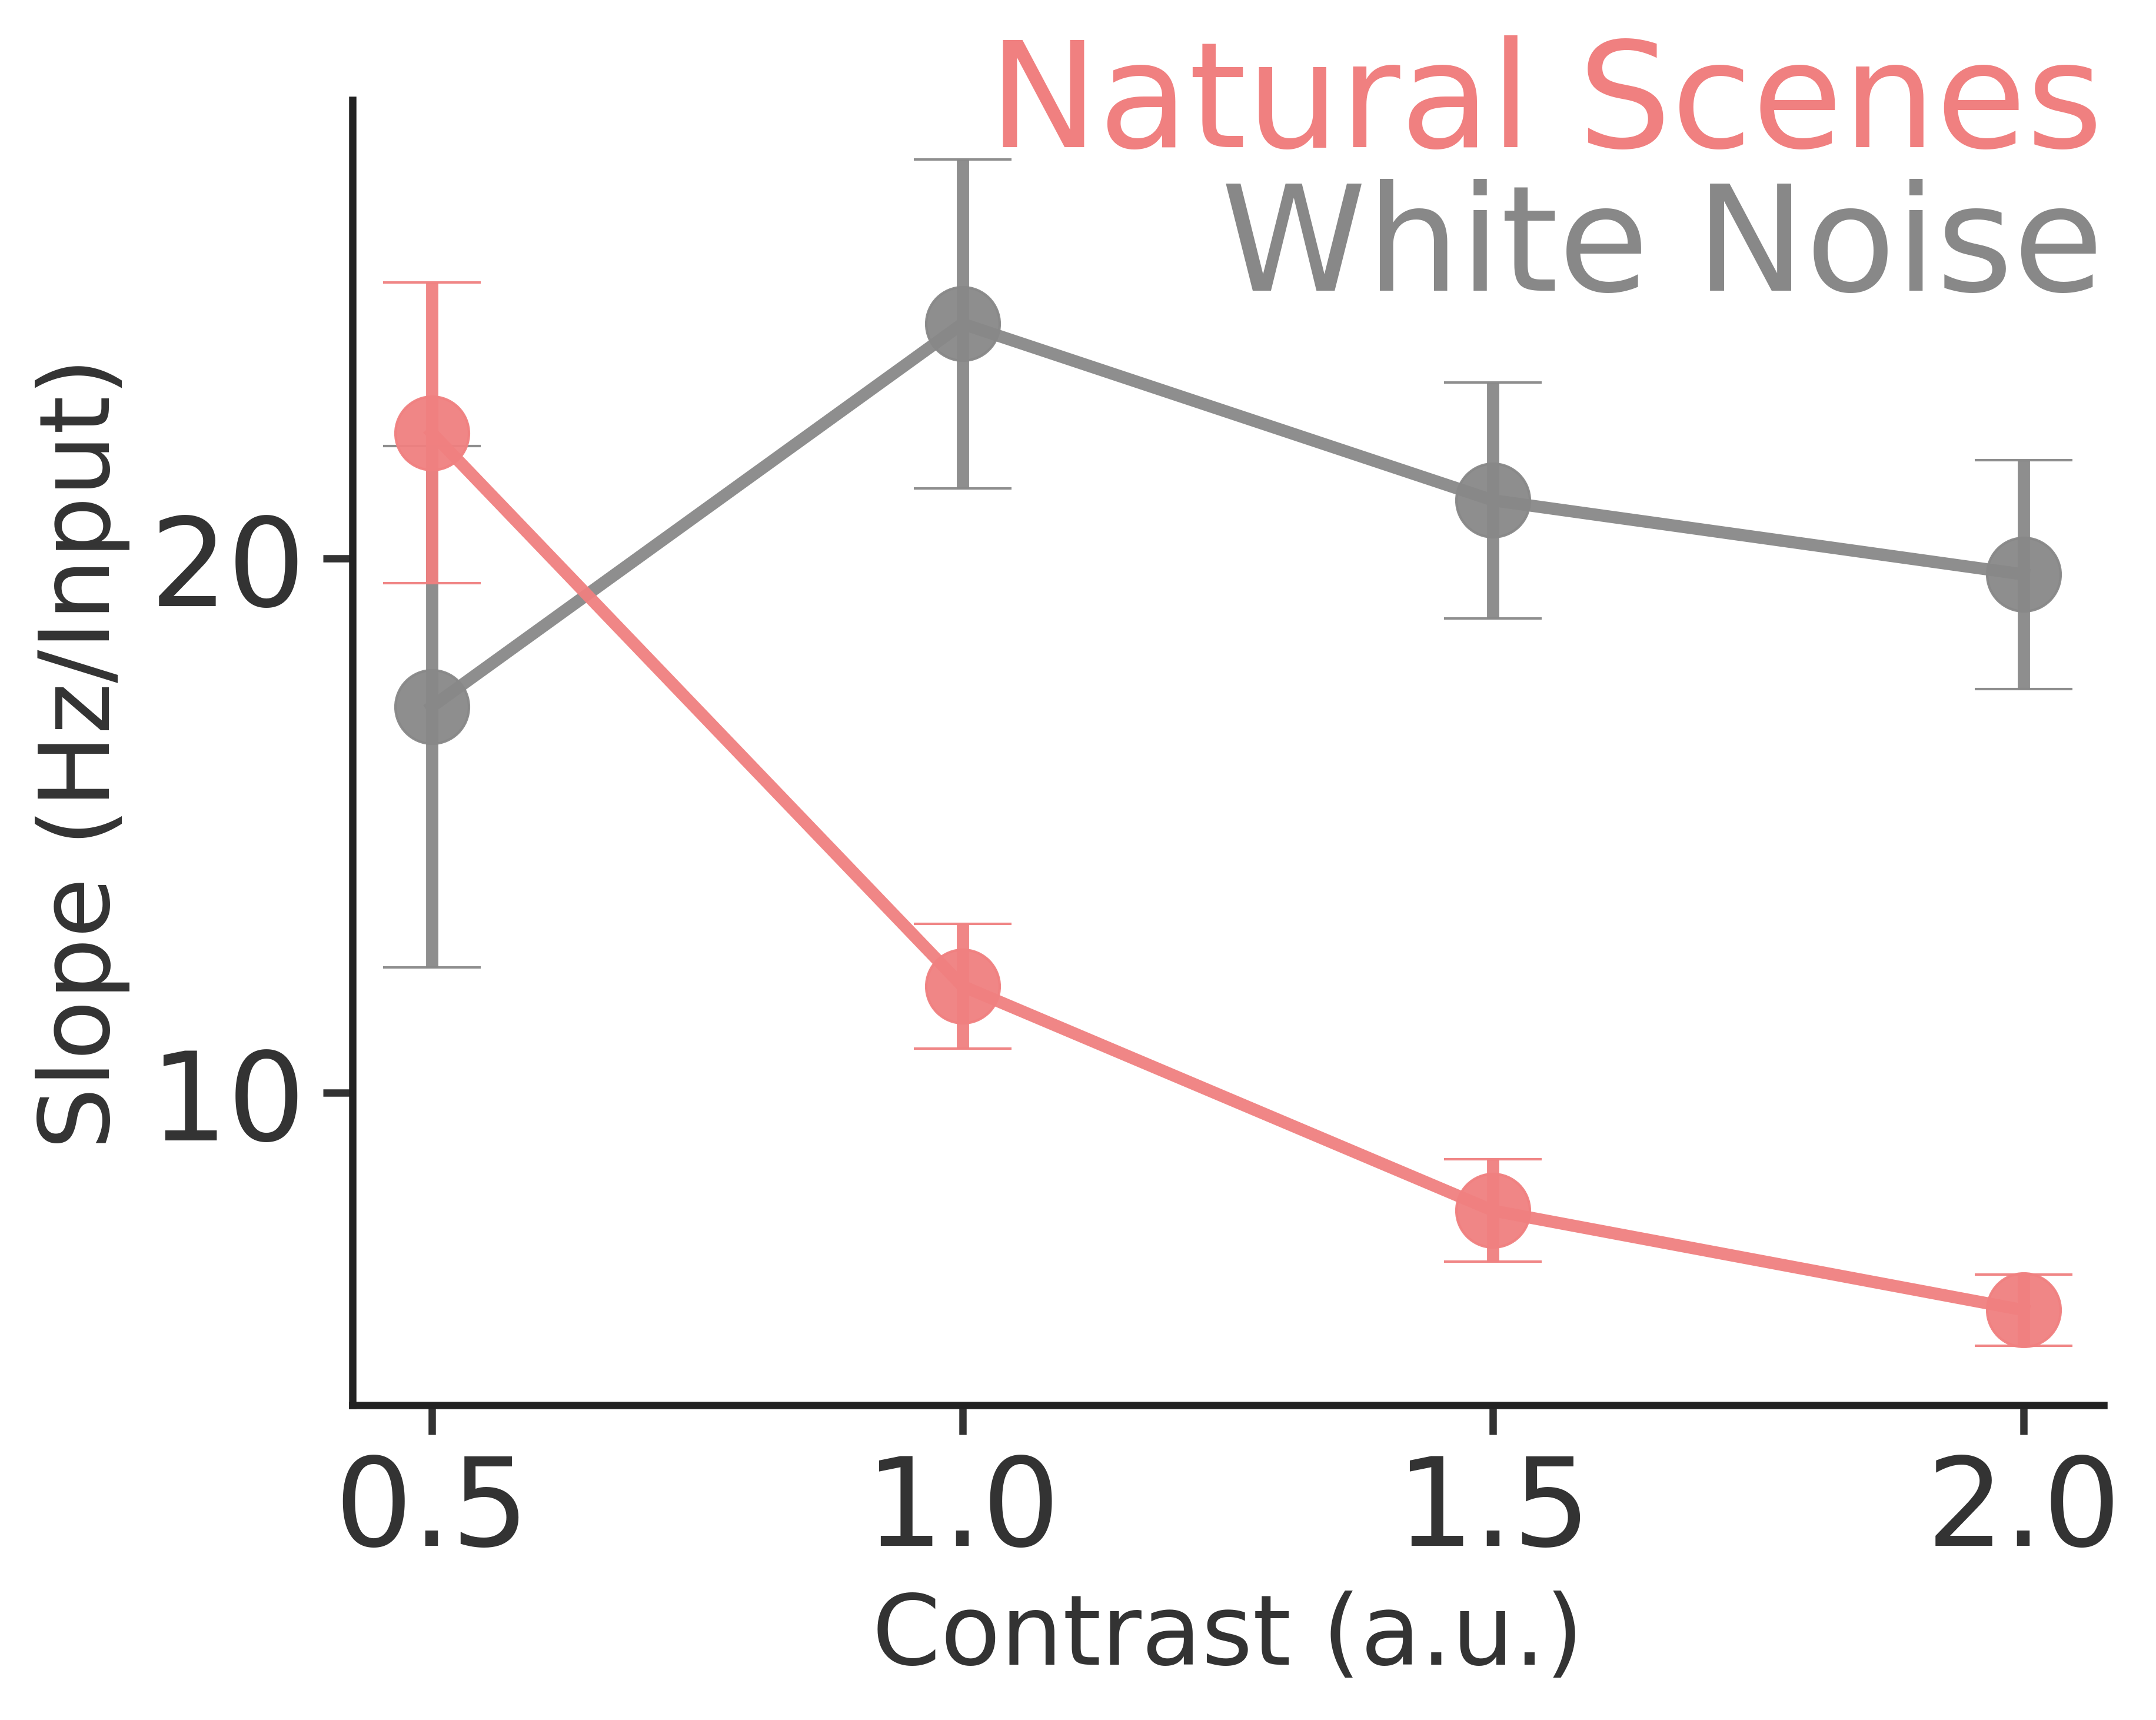

In [44]:
# plt.plot(contrasts, [np.mean(gain_slopes_no_nones['naturalscene'][contrast]) for contrast in contrasts], 'o')
legendsize = 30
ticksize = 25
nat_color = 'lightcoral'
whit_color = '#888888'
alpha = 0.95
capsize = 10
plt.errorbar(contrasts, [np.mean(gain_slopes_no_nones['whitenoise'][contrast]) for contrast in contrasts], 
             yerr=[sem(gain_slopes_no_nones['whitenoise'][contrast]) for contrast in contrasts],
             fmt='o', color=whit_color, label='white noise', alpha=alpha, capsize=capsize)
plt.errorbar(contrasts, [np.mean(gain_slopes_no_nones['naturalscene'][contrast]) for contrast in contrasts], 
             yerr=[sem(gain_slopes_no_nones['naturalscene'][contrast]) for contrast in contrasts],
             fmt='o', color=nat_color, label='natural scenes', alpha=alpha, capsize=capsize)
plt.plot(contrasts, [np.mean(gain_slopes_no_nones['whitenoise'][contrast]) for contrast in contrasts], 
             color=whit_color, label='white noise', alpha=alpha)
plt.plot(contrasts, [np.mean(gain_slopes_no_nones['naturalscene'][contrast]) for contrast in contrasts], 
             color=nat_color, label='natural scenes', alpha=alpha)
plt.xlabel('Contrast (a.u.)', fontsize=20)
plt.ylabel('Slope (Hz/Input)', fontsize=20)

ax1 = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.locator_params(nbins=4)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)

plt.text(1,.94, 'White Noise', ha="right", va="top", transform=plt.gca().transAxes, 
                                                                     color=whit_color,
                                                                     fontsize=legendsize)
plt.text(1,1.05, 'Natural Scenes', ha="right", va="top", transform=plt.gca().transAxes, 
                                                                         color=nat_color,
                                                                         fontsize=legendsize)
folder_name = "contrast_adapt"
folder = os.path.join(savefolder, "contrast_adapt")
if not os.path.exists(folder):
    os.makedirs(folder)
save_name = os.path.join(folder, "{}nonlinearity_slopes".format(prename))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()

captions[save_name.split("/")[-1]] = """
Slopes of the contrast adaptation nonlinearity for different contrasts, averaged over all cells.
"""

with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions.items():
        f.write(k+":\n")
        f.write(v+"\n\n")

In [34]:
gs = gain_slopes
fits = {k: [] for k in gs.keys()}

for stim in gs.keys():
    contrasts = list(gs[stim].keys())
    for ci in range(len(gs[stim][contrasts[0]])):
        slopes = [gs[stim][c][ci] for c in contrasts if gs[stim][c][ci] is not None]
        temp_contrasts = [c for c in contrasts if gs[stim][c][ci] is not None]
        fits[stim].append(np.polyfit(temp_contrasts, slopes, 1))
        
# Drop Cells with None Slopes
wn_slopes = [fits["whitenoise"][i][0] for i in range(len(fits["whitenoise"]))]
ns_slopes = [fits["naturalscene"][i][0] for i in range(len(fits["naturalscene"]))]


df = pd.DataFrame({
    "White Noise": wn_slopes,
    "Natural Scenes": ns_slopes,
    "Cell Idx": np.arange(len(ns_slopes)),
})
df = pd.melt(df, id_vars="Cell Idx", value_vars=["White Noise", "Natural Scenes"], var_name="Stim Type", value_name="Slope")
df.head()
    

,Cell Idx,Stim Type,Slope
0,0,White Noise,-20.809628
1,1,White Noise,8.880114
2,2,White Noise,-2.125088
3,3,White Noise,-10.763519
4,4,White Noise,2.545704


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial Narrow, PT Sans
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial Narrow, PT Sans
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial Narrow, PT Sans
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial Narrow, PT Sans


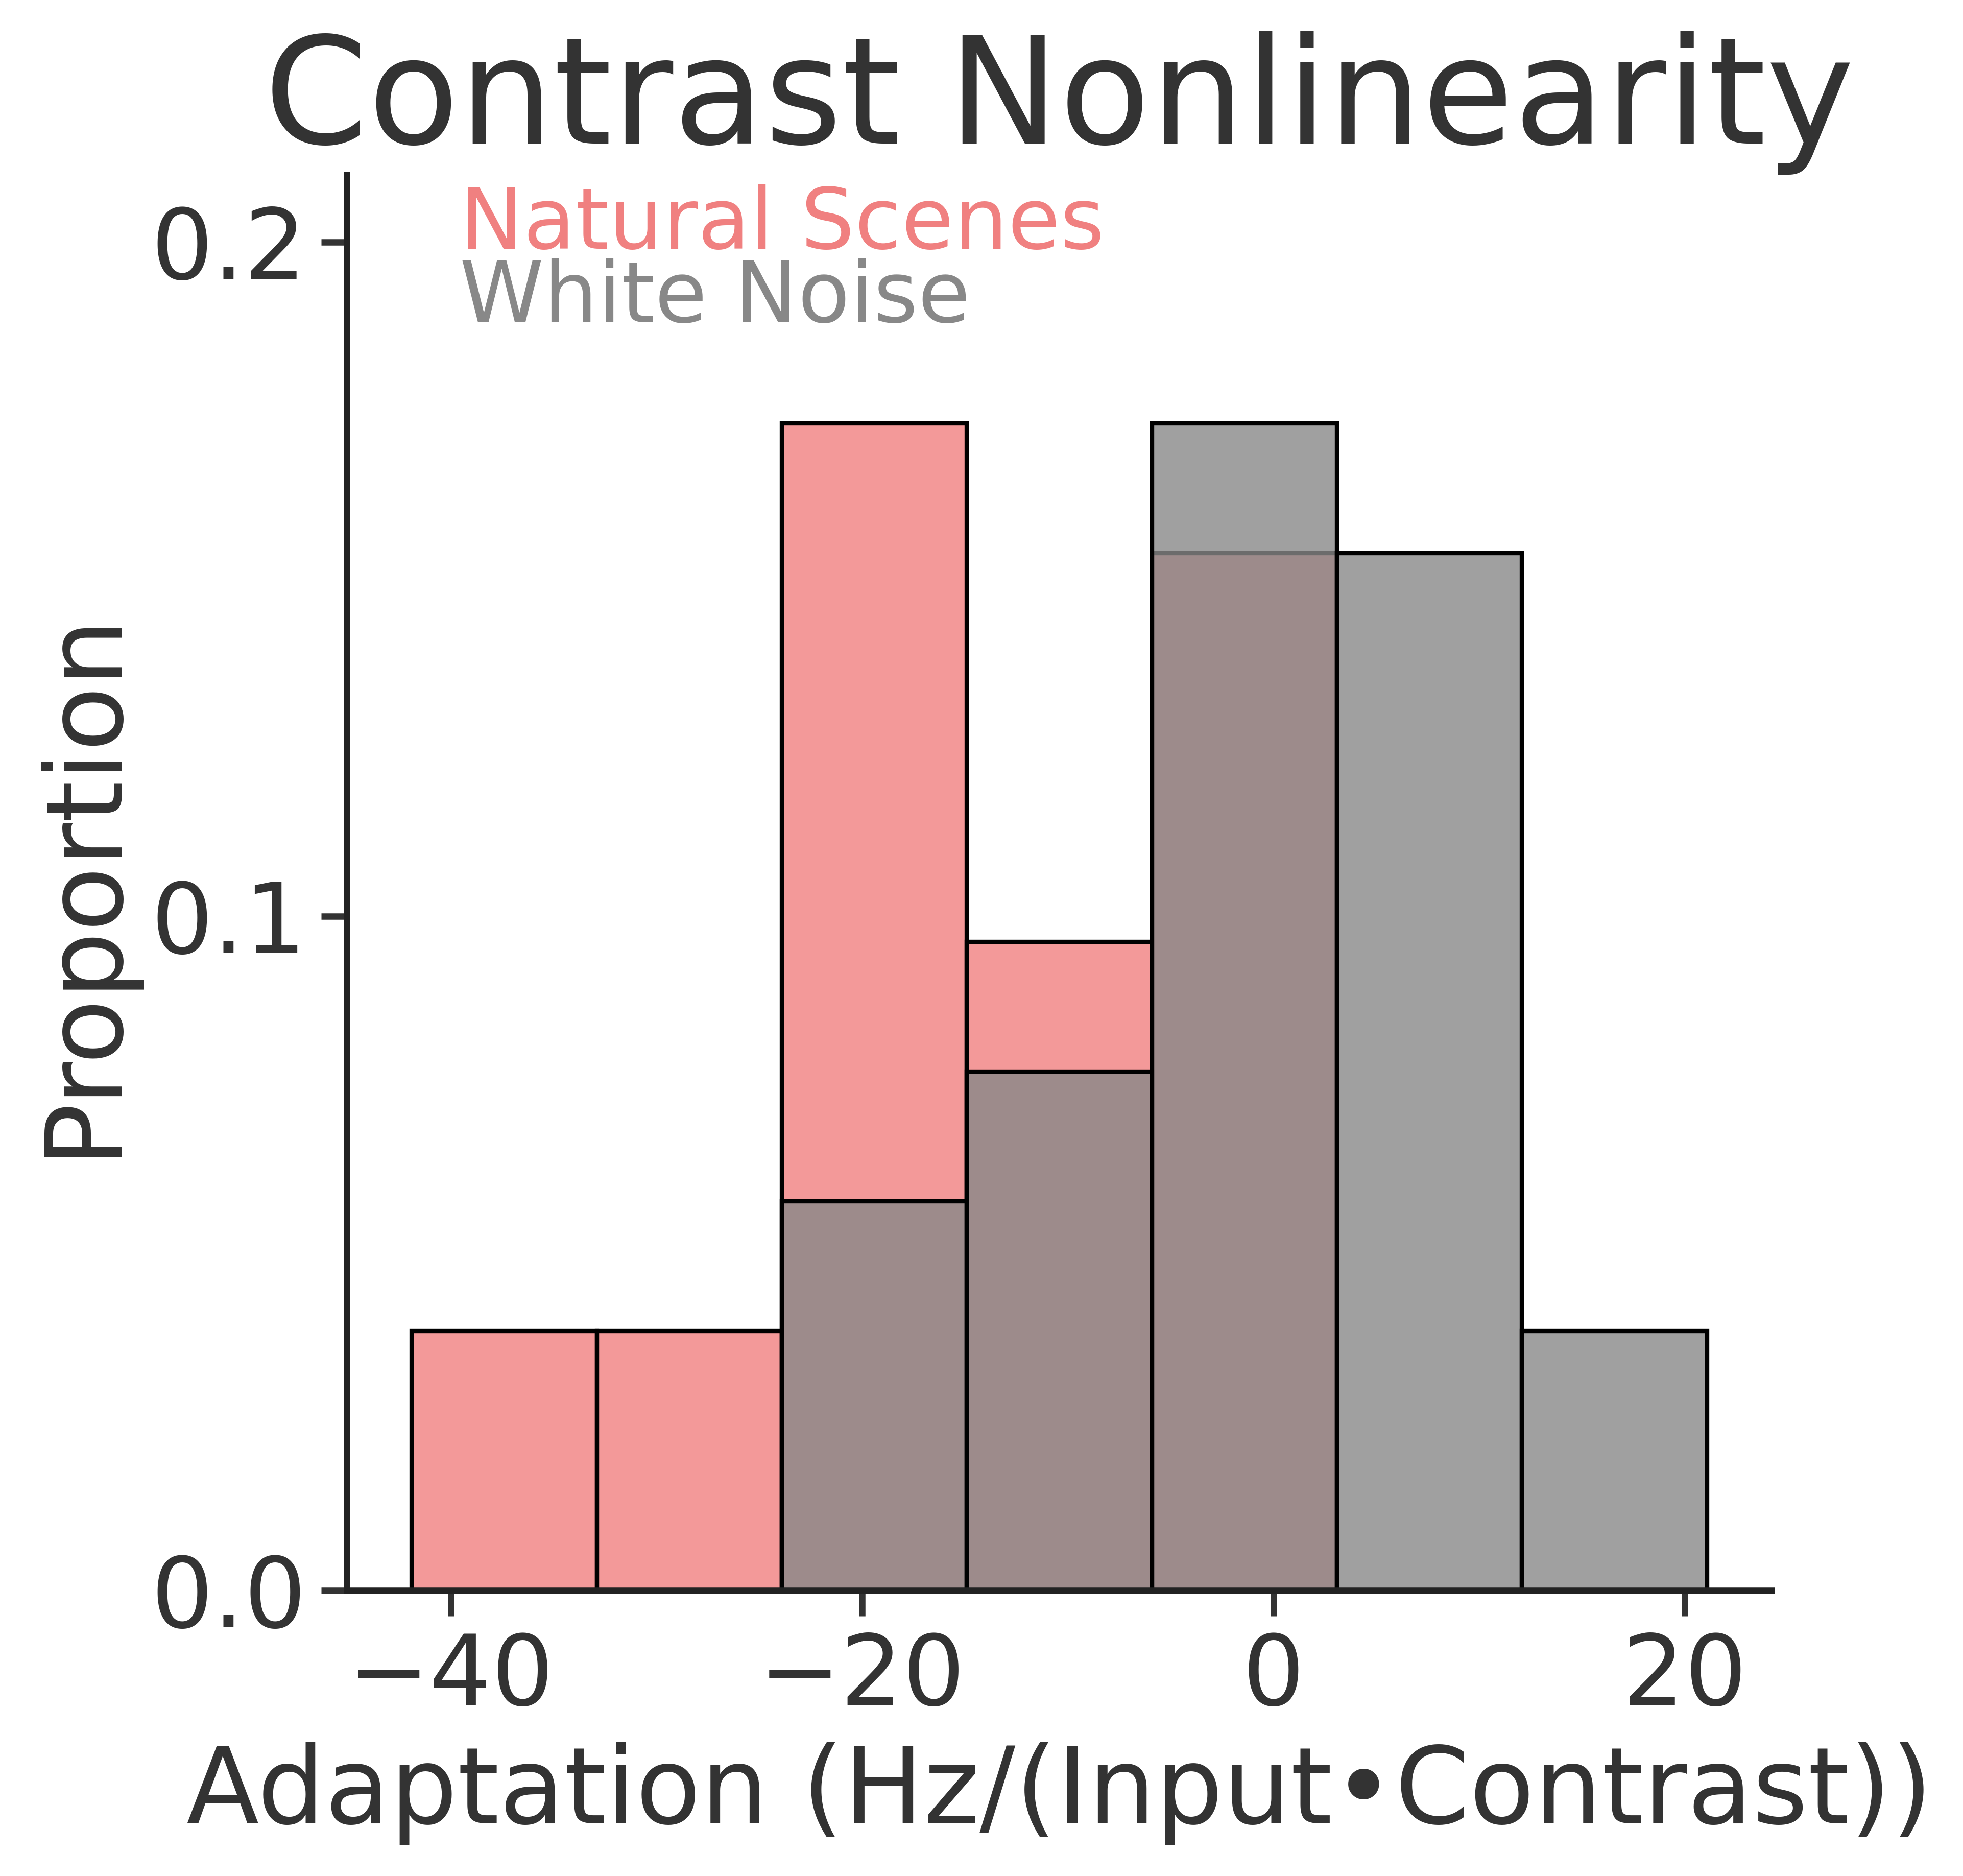

In [35]:
fontsize = 25
titlesize = 35
ticksize = 23
binwidth = 1
alpha = 0.8

fig = plt.figure(figsize=(6,6))

ax = plt.gca()
sns.histplot(x="Slope", data=df, stat="proportion", hue="Stim Type", ax=ax,
             palette={"White Noise": whit_color, "Natural Scenes": nat_color}, alpha=alpha)
ylim = [0,0.21]
plt.ylim(ylim)
#yticks = [i/10 for i in range(0, int(ylim[1]*10)+1, 3)]
yticks = [0, 0.1, 0.2]
plt.yticks(yticks, fontsize=ticksize)
#plt.xticks([-8, -4, 0], fontsize=ticksize)
plt.ylabel("Proportion", fontsize=fontsize)
#plt.xlabel("Adaptation ($\dfrac{Hz}{Input•Contrast}$)", fontsize=fontsize)
plt.xlabel("Adaptation (Hz/(Input•Contrast))", fontsize=fontsize)
plt.title("Contrast Nonlinearity", fontsize=titlesize)
plt.legend().set_visible(False)
px = 0.25
py = 0.88
ax.annotate('White Noise', xy=(px, py), #xycoords='axes points',
            xycoords="figure fraction",
            size=20, ha='left', va='top',
            bbox=None,
            color=whit_color)
            
ax.annotate('Natural Scenes', xy=(px, py+0.04), #xycoords='axes points',
            xycoords="figure fraction",
            size=20, ha='left', va='top',
            bbox=None,
            color=nat_color)
            
plt.locator_params(nbins=4)
plt.yticks(fontsize=ticksize)
plt.xticks(fontsize=ticksize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


folder_name = "contrast_adapt"
folder = os.path.join(savefolder, "contrast_adapt")
if not os.path.exists(folder):
    os.makedirs(folder)
save_name = os.path.join(folder, "{}nonlinearity_slope_hist".format(prename))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()

captions[save_name.split("/")[-1]] = """
Histogram of the slope of the contrast adaptation nonlinearity for each cell.
"""

with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions.items():
        f.write(k+":\n")
        f.write(v+"\n\n")

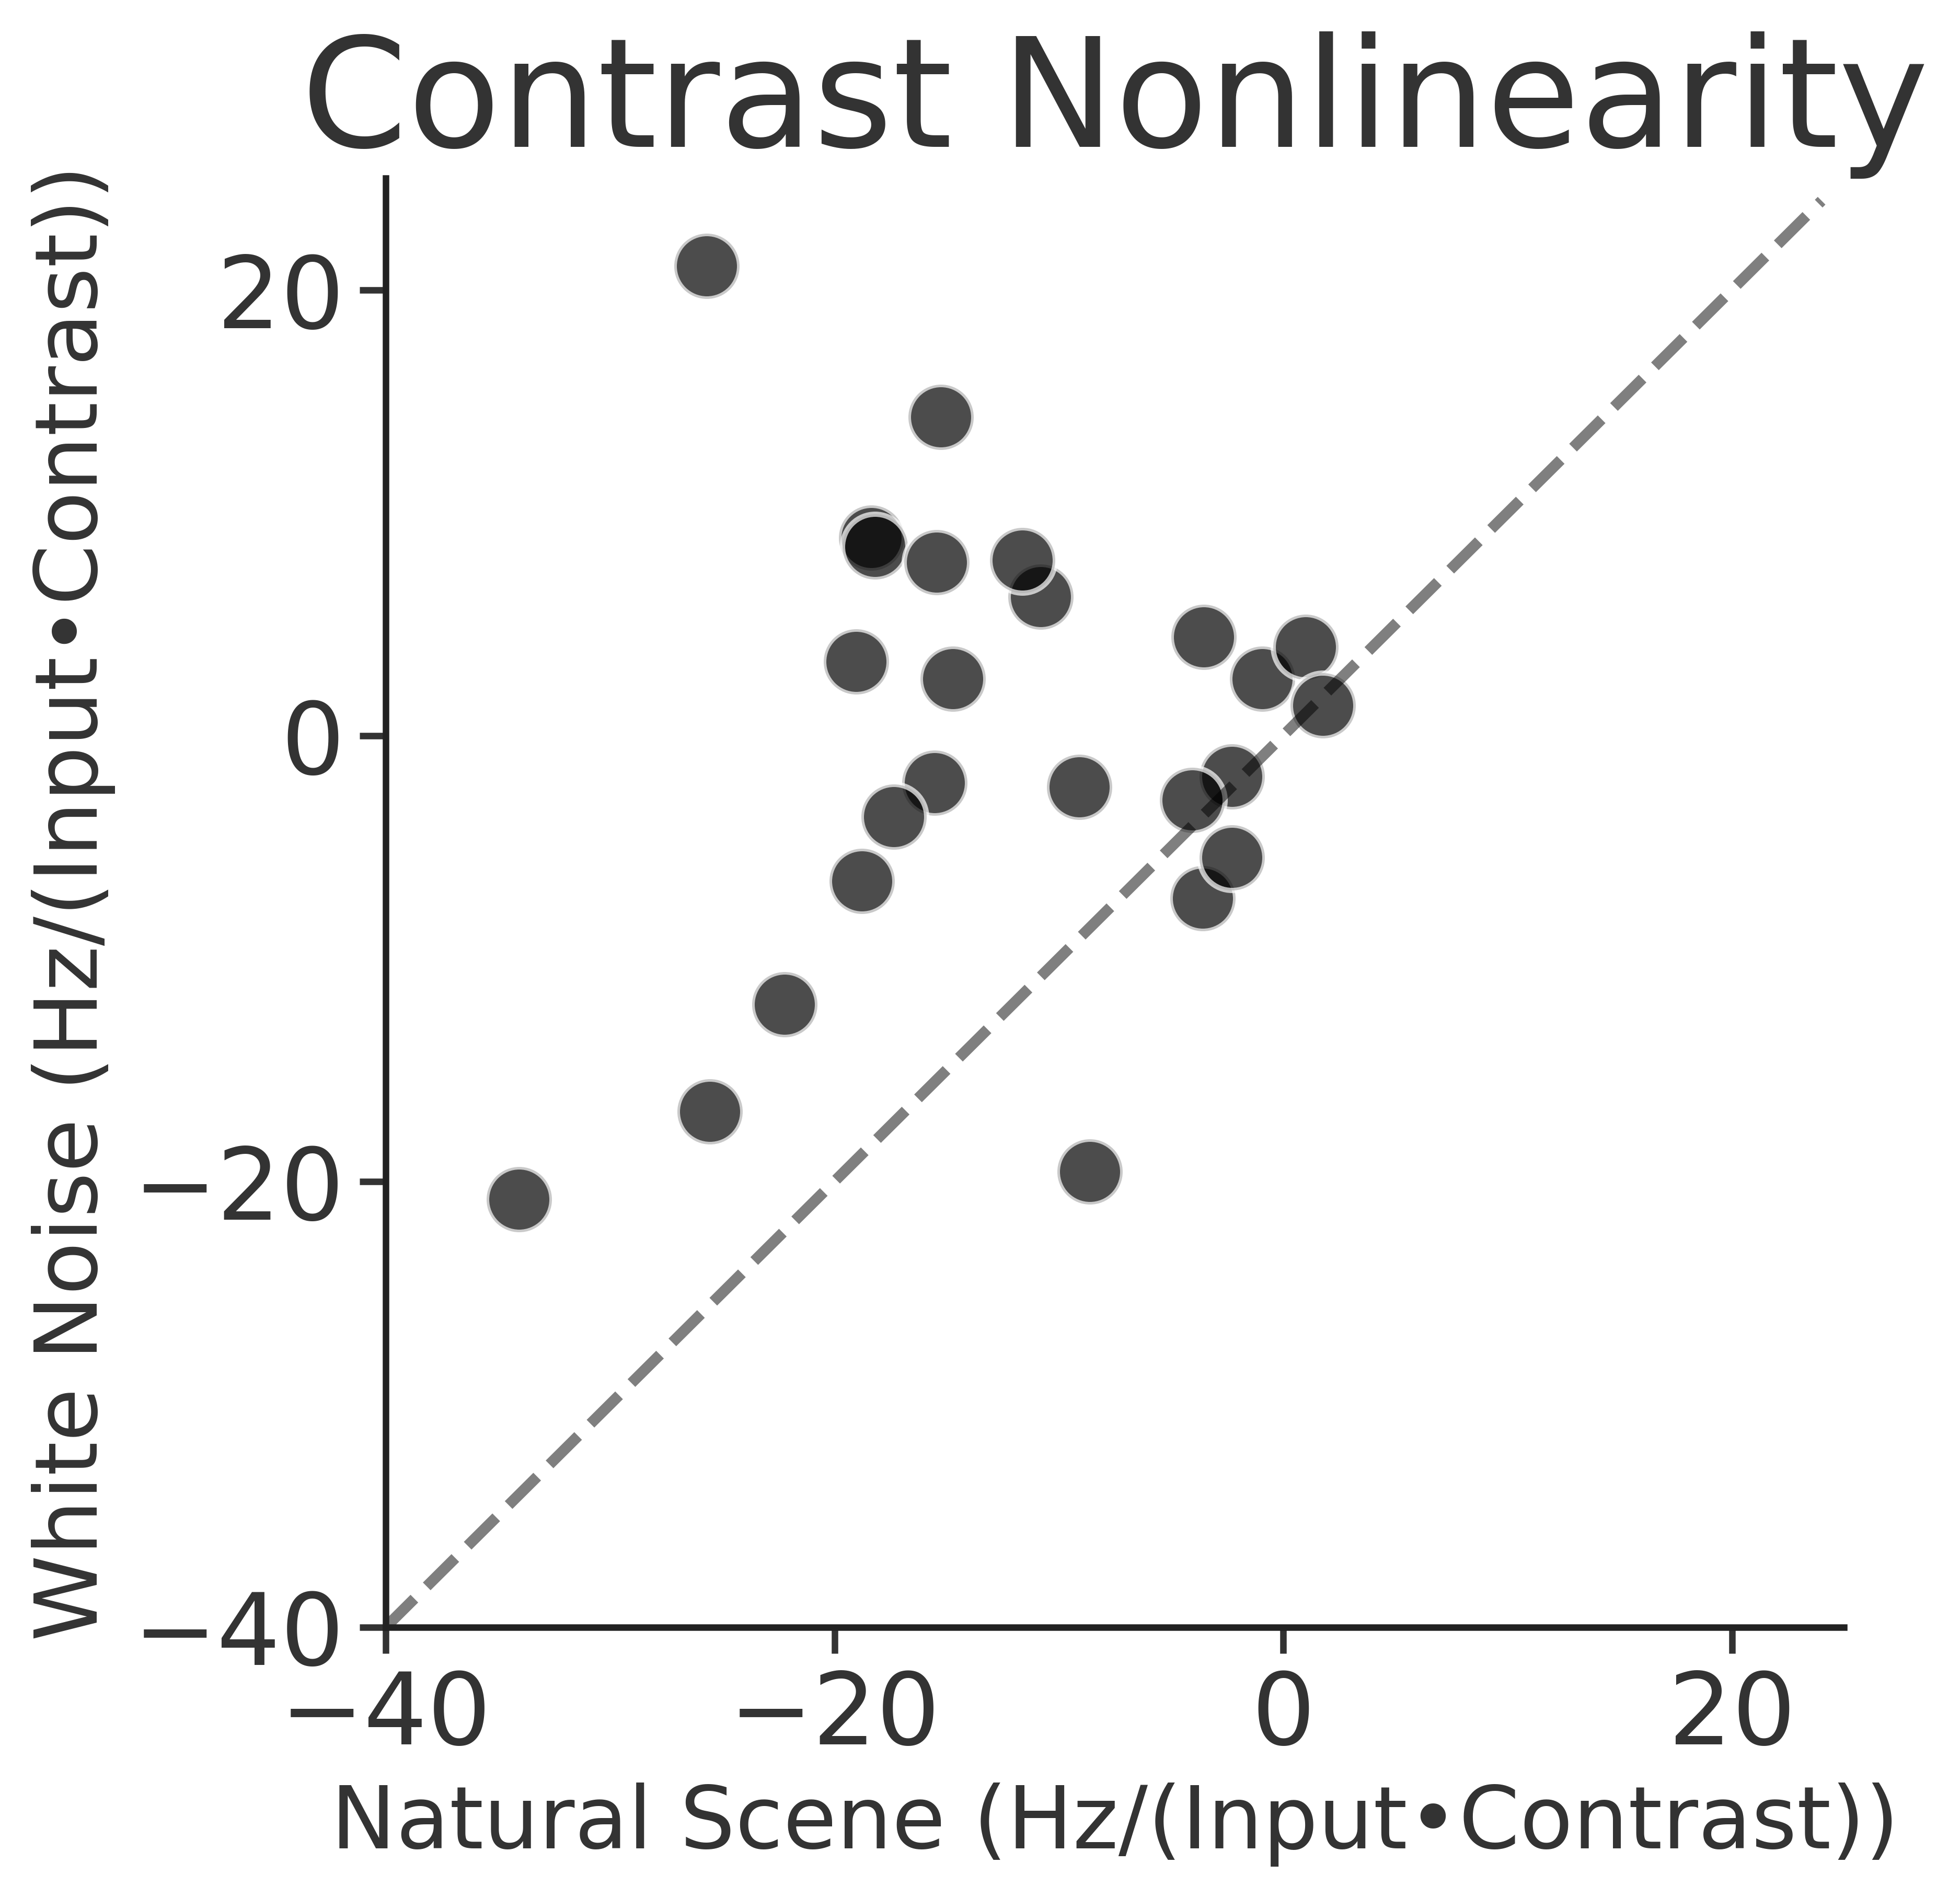

In [36]:
alpha = 0.7
fontsize = 20

x = []
y = []
for w,n in zip(wn_slopes, ns_slopes):
    if w is None or n is None: continue
    x.append(n)
    y.append(w)

fig = plt.figure(figsize=(6,6))

ax = plt.gca()
sns.scatterplot(x,y, ax=ax, alpha=alpha, color="black")
#ylim = [0,0.42]
#yticks = [i/10 for i in range(int(ylim[1]*10)+1)]
ticks = [-40,-20,0,20]
plt.xticks(ticks, fontsize=ticksize)
plt.yticks(ticks, fontsize=ticksize)
lim = [-40, 25]
ax.plot(np.arange(lim[0], lim[1]), np.arange(lim[0], lim[1]), "--k", alpha=0.5)
plt.ylim(lim)
plt.xlim(lim)
plt.ylabel("White Noise (Hz/(Input•Contrast))", fontsize=fontsize)
plt.xlabel("Natural Scene (Hz/(Input•Contrast))", fontsize=fontsize)
plt.title("Contrast Nonlinearity", fontsize=titlesize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


folder_name = "contrast_adapt"
folder = os.path.join(savefolder, folder_name)
if not os.path.exists(folder):
    os.makedirs(folder)
save_name = os.path.join(folder, "{}nonlinearity_slope_scatter".format(prename))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()

captions[save_name.split("/")[-1]] = """
Scatter plot of the trend of the nonlinearity slope for different contrasts.
"""

with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions.items():
        f.write(k+":\n")
        f.write(v+"\n\n")

# Contrast Rescaling Sanity Check

In [44]:
for contrast in [0.1, 0.35, 0.5, 0.75, 1, 1.5, 2]:
    print("Contrast:", contrast)
    model = models["naturalscene"]["15-10-07"]
    stats = model.norm_stats
    #sta = stas["naturalscene"]["15-10-07"][contrast][0]
    #normed_sta = normed_stas["naturalscene"]["15-10-07"][contrast][0]
    stim = white(4040, contrast=contrast)
    print("Raw Model Input:")
    print("\tmean:", stim.mean())
    print("\tstd:", stim.std())
    print("\tmin:", np.min(stim))
    print("\tmax:", np.max(stim))
    print("\tcontrast:", stim.std()/stim.mean())
    temp = stim*stats["std"]+stats["mean"]
    print("Transformed to Pixel Space:")
    print("\tmean:", temp.mean())
    print("\tstd:", temp.std())
    print("\tmin:", np.min(temp))
    print("\tmax:", np.max(temp))
    print("\tcontrast:", temp.std()/temp.mean())
    #normed_sta, theta, error = normalize_filter(sta, stim, contrast)
    print()
    print()

Contrast: 0.1
Raw Model Input:
	mean: 8.301703925508302e-05
	std: 0.09995172197307432
	min: -0.5098030535392658
	max: 0.5214022109855762
	contrast: 1203.990444250328
Transformed to Pixel Space:
	mean: 51.49620073409397
	std: 5.3600742910211805
	min: 24.15272766222448
	max: 79.45279371445609
	contrast: 0.10408679115374911


Contrast: 0.35
Raw Model Input:
	mean: -0.00018403063165309974
	std: 0.350071330300598
	min: -1.6935144746804152
	max: 1.8092160050376445
	contrast: -1902.2448988844817
Transformed to Pixel Space:
	mean: 51.48187986670853
	std: 18.773146680487404
	min: -39.32573004914961
	max: 148.5139111505364
	contrast: 0.3646554230166587


Contrast: 0.5
Raw Model Input:
	mean: -0.0005437974876182147
	std: 0.4997890891901443
	min: -2.4469428077877518
	max: 2.5132156700360575
	contrast: -919.0720821075813
Transformed to Pixel Space:
	mean: 51.4625867816336
	std: 26.802005958663187
	min: -79.72955460260229
	max: 186.2670426699918
	contrast: 0.5208056499839319


Contrast: 0.75
Raw Mod

In [77]:
## plt.plot(contrasts, [np.nanmean(gain_slopes['naturalscene'][contrast]) for contrast in contrasts], 'o')
#nat_color = 'lightcoral'
#whit_color = '#888888'
#plt.errorbar(contrasts, [np.nanmean(gain_slopes['naturalscene'][contrast]) for contrast in contrasts], 
#             yerr=[np.nanstd(gain_slopes['naturalscene'][contrast]) for contrast in contrasts],
#             fmt='o', color=nat_color, label='natural scenes')
#plt.errorbar(contrasts, [np.nanmean(gain_slopes['whitenoise'][contrast]) for contrast in contrasts], 
#             yerr=[np.nanstd(gain_slopes['whitenoise'][contrast]) for contrast in contrasts],
#             fmt='o', color=whit_color, label='white noise')
#plt.plot(contrasts, [np.nanmean(gain_slopes['naturalscene'][contrast]) for contrast in contrasts], 
#             color=nat_color, label='natural scenes')
#plt.plot(contrasts, [np.nanmean(gain_slopes['whitenoise'][contrast]) for contrast in contrasts], 
#             color=whit_color, label='white noise')
#plt.xlabel('Contrast', fontsize=20)
#plt.ylabel('Slope (Hz/Filtered Input)', fontsize=20)
#
#ax1 = plt.gca()
#ax1.spines['right'].set_visible(False)
#ax1.spines['top'].set_visible(False)
#plt.locator_params(nbins=4)
#plt.text(1,.9, 'White Noise', ha="right", va="top", transform=plt.gca().transAxes, 
#                                                                     color=whit_color,
#                                                                     fontsize=35)
#plt.text(1,1.05, 'Natural Scene', ha="right", va="top", transform=plt.gca().transAxes, 
#                                                                         color=nat_color,
#                                                                         fontsize=35)
##plt.savefig(prepath+"nonlin_slopes.png")
##plt.savefig(prepath+"nonlin_slopes.pdf")

In [42]:
from scipy.stats import sem
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [43]:
# Create figure for slope of nonlinearity vs stimulus contrast.
plt.figure(figsize=(5, 3))
plt.errorbar(contrasts, [np.mean(gain_changes['naturalscene'][contrast]) for contrast in contrasts],
             yerr=[sem(gain_changes['naturalscene'][contrast]) for contrast in contrasts],
             fmt='o', color='#F07F7F', label='natural scenes')
plt.errorbar(contrasts, [np.mean(gain_changes['whitenoise'][contrast]) for contrast in contrasts], 
             yerr=[sem(gain_changes['whitenoise'][contrast]) for contrast in contrasts],
             fmt='o', color='#7F7F7F', label='white noise')
plt.xlabel('Contrast', fontsize=20)
plt.ylabel('Slope (Hz/Filtered Input)', fontsize=20)

ax1 = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
majorLocator = MultipleLocator(10)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.5)
ax1.xaxis.set_major_locator(minorLocator)
ax1.yaxis.set_major_locator(majorLocator)
ax1.yaxis.set_major_formatter(majorFormatter)

#plt.savefig(prepath+'fast_contrast_gain_changes.png', dpi=200)

NameError: name 'gain_changes' is not defined

<Figure size 3000x1800 with 0 Axes>

In [46]:
len(gain_slopes_no_nones['naturalscene'][0.5])

25

In [48]:
dd.io.save(prepath+'fast_contrast_gain_changes.h5', gain_slopes_no_nones)

In [50]:
with open(prepath+"fast_contrast_gain_changes.p",'wb') as f:
    pickle.dump(gain_slopes_no_nones, f)